In [1]:
import pathlib
import re
import numpy as np
# import scipy.fft as sp_fft
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.visualization import hist

In [2]:
data = {
    "local_slow": {"dir": pathlib.Path("../out/gains/constant/slow_sample/psd_fits")},
    "local_fast": {"dir": pathlib.Path("../out/gains/constant/fast_sample/psd_fits")},
    "jz_fast": {
        "dir": pathlib.Path("../jz_out/gains/constant/fast_sample/e-01/psd_fits")
    },
}

In [3]:
pattern = r"noise_fit_(\d+)_(.*).npz"
expr = re.compile(pattern)

In [4]:
def get_data(dir: pathlib.Path):
    result = {}
    for file in dir.iterdir():
        match_ = expr.match(file.name)
        if match_:
            uid, det = match_.group(1, 2)
            uid = int(uid)
            if uid not in result:
                # create sub-dict with this observation
                result[uid] = {}
            result[uid].update({det: np.load(file)})
        else:
            print(f"Could not extract information from file '{file.name}'")
    return result

In [5]:
for name in data:
    data[name]["data"] = get_data(data[name]["dir"])

In [6]:
def plot_psd(ax, fit_info):
    # rate = fit_info.get("rate", 37.0)
    # nfft = int(fit_info["nn"])
    # freqs = sp_fft.rfftfreq(nfft, d=1.0 / rate)
    ax.plot(fit_info["freqs"], fit_info["periodogram"], alpha=0.5, linewidth=0.5)

In [21]:
def hists_params(axs, det_info):
    ndet = len(det_info)
    names = ["log_s2", "alpha", "fknee", "fmin"]
    collect = {name: np.zeros(ndet) for name in names}
    for idet, fit_info in enumerate(det_info.values()):
        for name, val in zip(names, fit_info["popt"]):
            collect[name][idet] = val
    for name, ax, c in zip(names, axs, list("bgrc")):
        # hist(collect[name], ax=ax, bins="blocks", color=c, label=name)
        hist(collect[name], ax=ax, bins=10, color=c, label=name)
        ax.legend()

In [22]:
def produce_plot(name: str, nmax: int = 0):
    d = data[name]["data"]
    nobs = len(d)
    if nmax > 0:
        nobs = min(nobs, nmax)

    fig = plt.figure(constrained_layout=True, figsize=(12, 4 * nobs))
    fig.suptitle(name, fontsize=18)
    spec = gridspec.GridSpec(2 * nobs, 4, figure=fig)

    plot_layout = False
    anno_opts = dict(xy=(0.5, 0.5), xycoords="axes fraction", va="center", ha="center")
    for iob, (uid, det_info) in enumerate(d.items()):
        # set up axes
        if plot_layout:
            ax_psd = fig.add_subplot(spec[2 * iob : 2 * (iob + 1), 0:2]).annotate(
                f"GridSpec[{2*iob}:{ 2 * (iob + 1)}, 0:2]", **anno_opts
            )
            axs_params: list = []
            for i in range(4):
                x, y = divmod(i, 2)
                ax = fig.add_subplot(spec[2 * iob + x, 2 + y]).annotate(
                    f"GridSpec[{2 * iob + x}, {2 + y}]", **anno_opts
                )
                axs_params.append(ax)
            continue
        ax_psd = fig.add_subplot(spec[2 * iob : 2 * (iob + 1), 0:2])
        axs_fit: list = []
        for i in range(4):
            x, y = divmod(i, 2)
            ax = fig.add_subplot(spec[2 * iob + x, 2 + y])
            axs_fit.append(ax)

        # plot PSDs of all dets for this observation
        for det, fit_info in det_info.items():
            plot_psd(ax_psd, fit_info)
        ax_psd.loglog()
        ax_psd.set_title(f"{uid=} - periodograms")
        ax_psd.set_xlabel("Frequency [Hz]")
        ax_psd.set_ylabel("Power [$K^2$/Hz]")
        ax_psd.axhline(1e-10, color="k")
        # ax_psd.set_xlim(left=1.0)
        # ax_psd.set_ylim(bottom= 1e-11, top=1e-9)

        # histograms of corresponding fit parameters
        hists_params(axs_fit, det_info)
    plt.show()

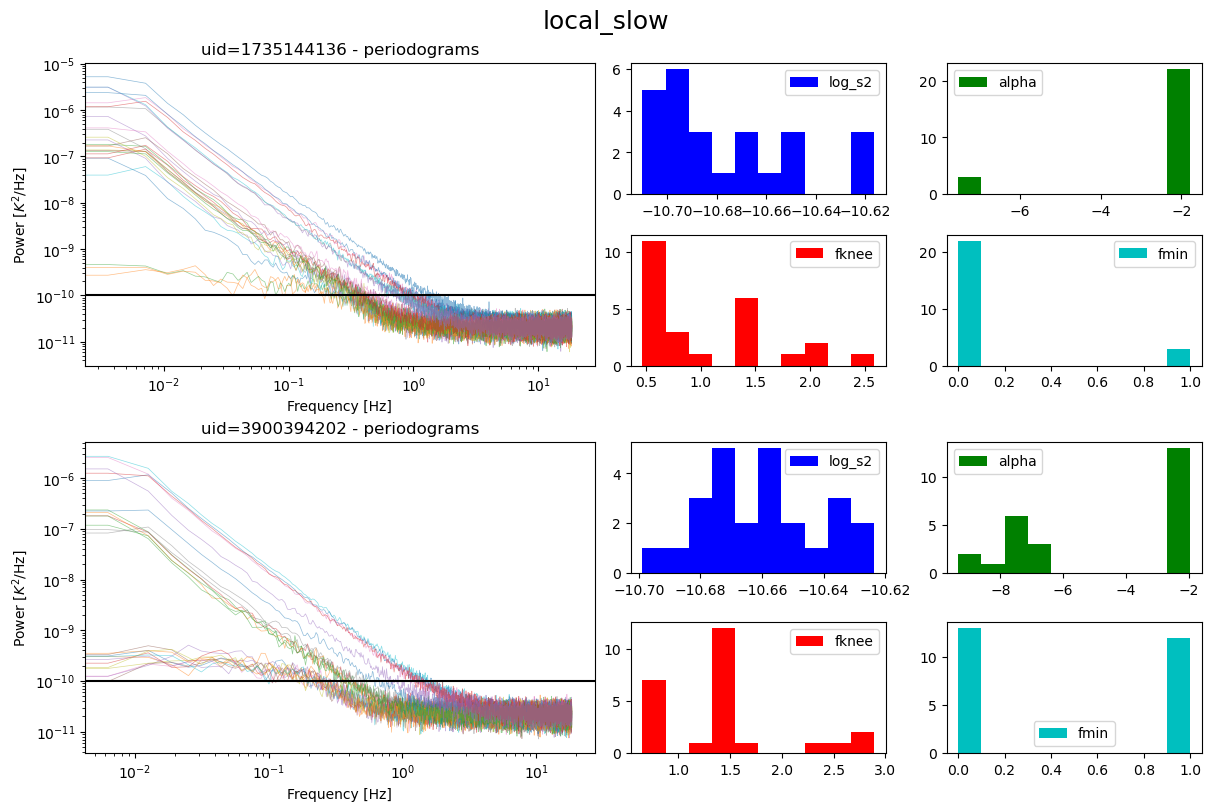

In [23]:
produce_plot("local_slow")

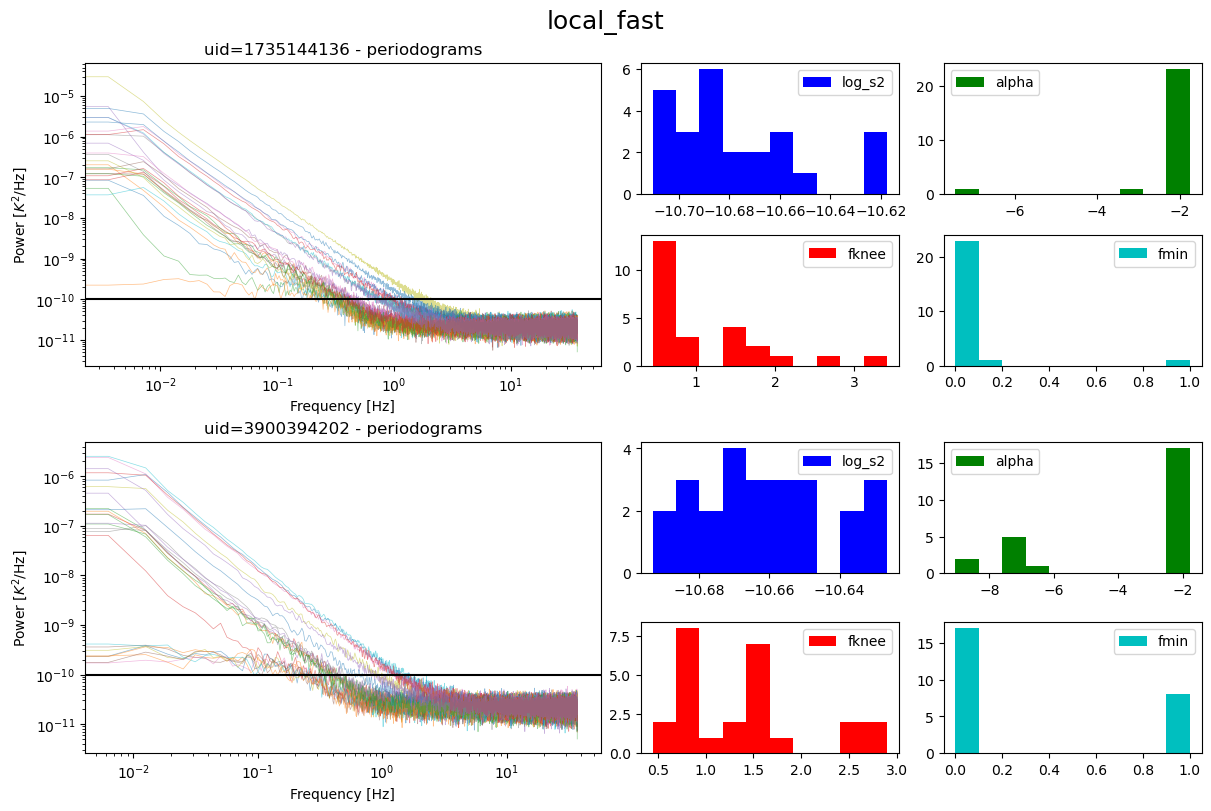

In [24]:
produce_plot("local_fast")

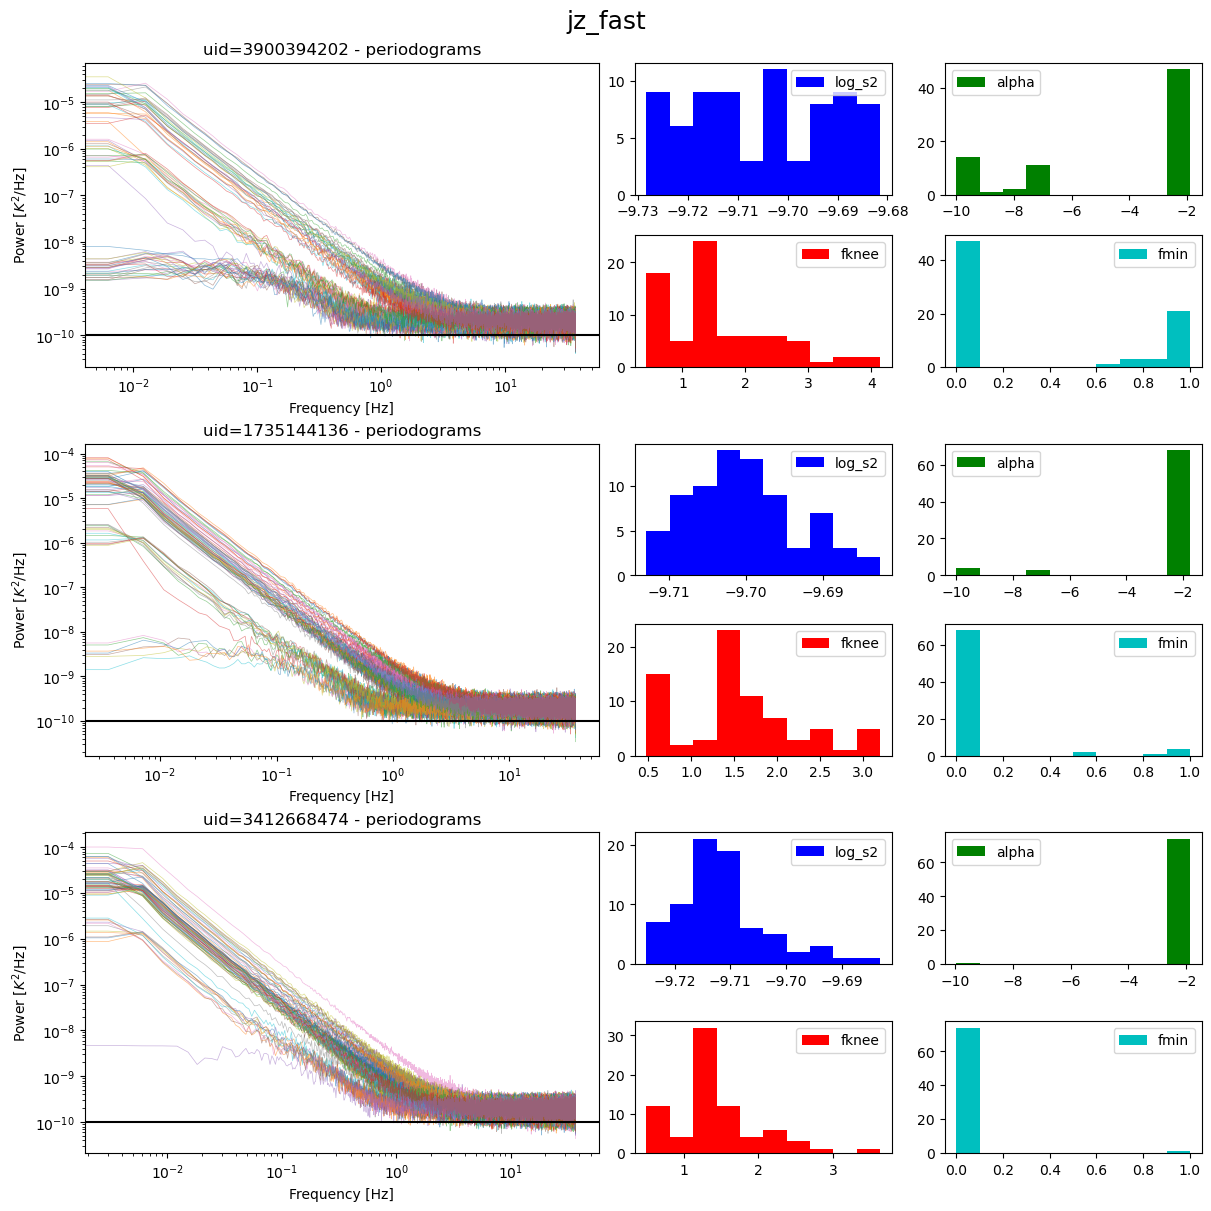

In [25]:
produce_plot("jz_fast")